<h1>Практическая работа: "Знакомство с алгоритма k-ближайших соседей (kNN)"</h1>

__K-ближайший сосед с использованием scikit-learn__

__Задача обучения__  
Набор данных "Ирисы Фишера". Нужно определить к какому классу принадлежит неопознанное растение ириса,
Классификация осуществляется на основе размеров чашелистиков и лепестков.

In [1]:
# Импорт необходимых библиотек
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from mlxtend.plotting import plot_decision_regions

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,5)

__Изучение набора данных__  
Набор данных "Ирисы Фишера" — это популярный многомерный набор данных, часто используемый в машинном обучении. 
Набор данных состоит из 150 образцов, равномерно распределенных по трем видам ирисов: 
ирис сетозный, ирис виргинский, ирис разноцветный. 
Каждый образец состоит из четырех атрибутов: длины и ширины чашелистиков и лепестков в сантиметрах.
Задача состоит в том, чтобы предсказать, к какому классу принадлежит неопознанное растение ириса,
основываясь на размерах чашелистиков и лепестков.

In [4]:
dataset = datasets.load_iris()
df = pd.DataFrame(data=np.c_[dataset['data'], dataset['target']],
                    columns=dataset['feature_names'] + ['target'])

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


__Описания наборов данных__

In [5]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    float64
dtypes: float64(5)
memory usage: 6.0 KB


In [6]:
dict(zip( dataset.target_names, df['target'].unique()))

{np.str_('setosa'): np.float64(0.0),
 np.str_('versicolor'): np.float64(1.0),
 np.str_('virginica'): np.float64(2.0)}

In [7]:
temp_df = df.copy()

temp_df['target'] = temp_df['target'].map(dict(zip( temp_df['target'].unique(), dataset.target_names)))

<Axes: xlabel='target', ylabel='count'>

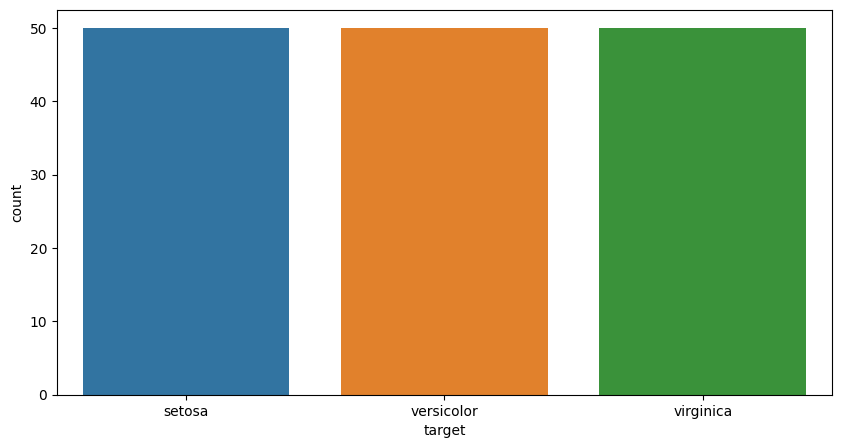

In [8]:
sns.countplot(x='target', hue='target', data=temp_df)

Из графика выше мы видим, что наши данные идеально сбалансированы.

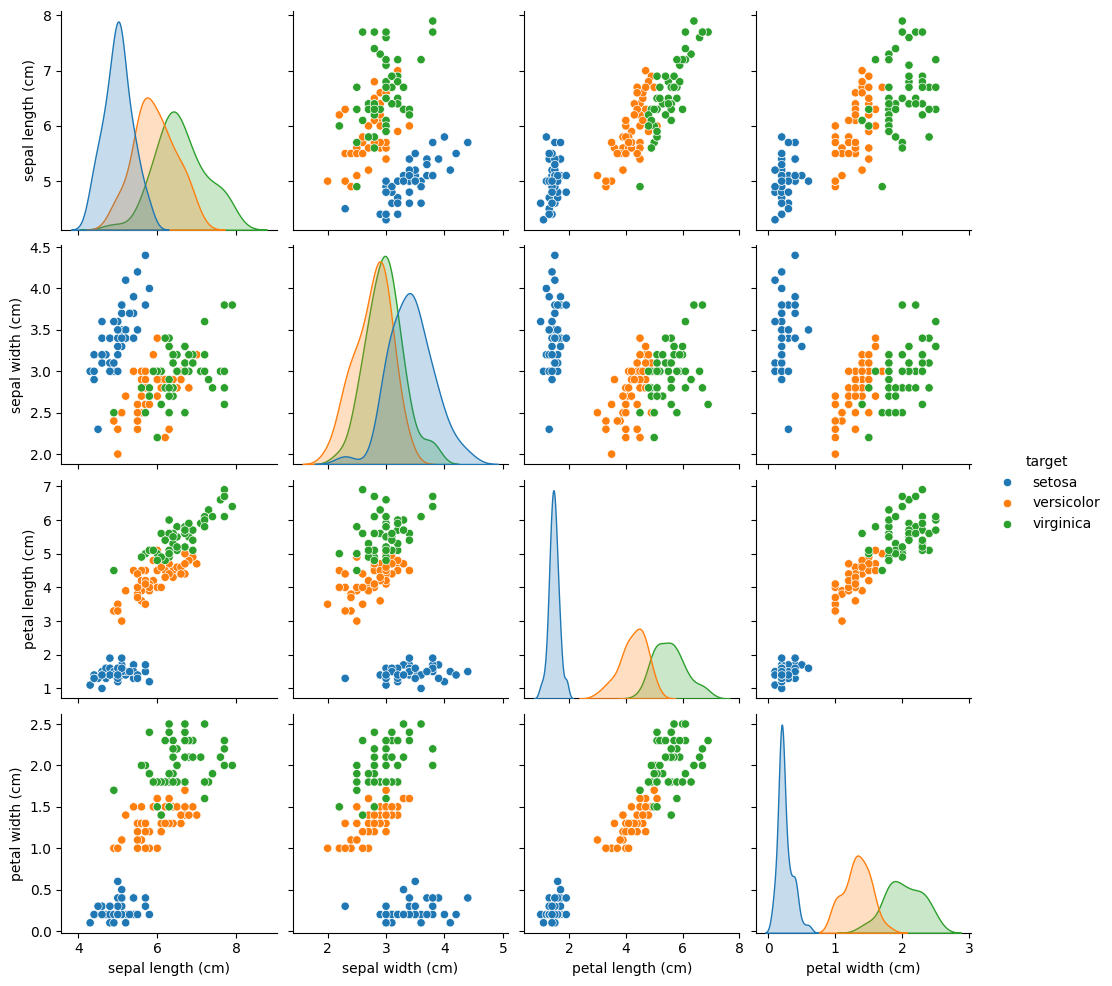

In [9]:
sns.pairplot(temp_df, hue='target')

На графике выше мы можем видеть взаимосвязь между каждой функцией. Мы можем увидеть, являются ли признаки разделимыми или нет.

<h2>Синтетический набор данных KNN</h2>

In [10]:
from IPython.display import display, Javascript, HTML
from IPython.display import IFrame
display(HTML('build.html'))

<h2>Модели КNN</h2>

Теперь мы построим разные модели для разных пар признаков, чтобы увидеть, насколько полезны признаки для определения их вида.

In [11]:
# Helper functions

def display_confusion_matrix(
    matrix, labels=None,
    title="Confusion Matrix",
    xlabel="Predicted",
    ylabel="Actual",
    figsize=None,
    cmap="Blues",
    vmin=None,
    vmax=None,
):
    """Display a confusion matrix. 
  
    Display the confusion matrix found in matrix using matplotlib.
  
    Parameters
    ----------
    matrix : array-like
        Confusion matrix to display, shape [n_classes, n_classes].
    
    labels : array-like, default=None
        Class labels for the confusion matrix, shape [n_classes].
        
    title : str, default='Confusion Matrix'
        Title displayed on the confusion matrix.
    
    xlabel : str, default='Predicted'
        x-label displayed on the confusion matrix.
    
    ylabel : str, default='Actual'
        y-label displayed on the confusion matrix.
    
    figsize : array-like
        Array-like, length two, specifying the figsize of the plot.
        
    cmap : matplotib.colors.Colormap or str, default='Blues'
        Colormap used when displaying the entries of the confusion matrix.
        
    vmin,vmax : int or float
        *vmin* and *vmax* define the data range that the colormap covers.
    """
    
    if labels is None:
        labels = [""]*len(matrix)
    if vmin is None:
        vmin = 0.
    if vmax is None:
        vmax = np.sum(matrix[0])
    t_hold = (vmax-vmin) / 2.
    fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(matrix, cmap=cmap)
    for row,col in itertools.product(range(len(labels)), range(len(labels))):
        color = "white" if matrix[row,col] > t_hold else "black"
        ax.text(col, row, matrix[row, col], horizontalalignment="center", color=color)
    tick_marks = np.arange(len(labels))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=40, ha="right")
    ax.set_ylabel(ylabel)
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    plt.show()

<h2>Модель 1 (длина чашелистика и ширина чашелистика)</h2>  
Для начала мы собираемся построить модель KNN с длиной и шириной чашелистика. Мы обучим модель этим двум функциям и оценим ее эффективность с помощью карты классификации и матрицы путаницы.

In [ ]:
X = df[['sepal length (cm)', 'sepal width (cm)']]
y_true = df['target']
model_1 = KNeighborsClassifier()
model_1.fit(X, y_true)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


<h3>Оценка модели 1</h3>

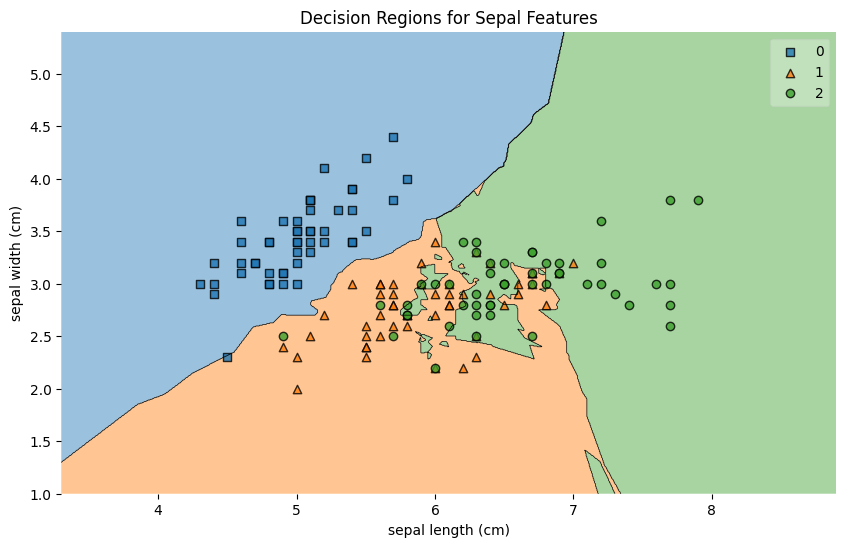

In [16]:
plt.figure(figsize=(10, 6))
plot_decision_regions(X.values, y_true.values.astype(int), model_1)
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.title('Decision Regions for Sepal Features')
plt.show()

[[49  1  0]
 [ 0 38 12]
 [ 0 12 38]]


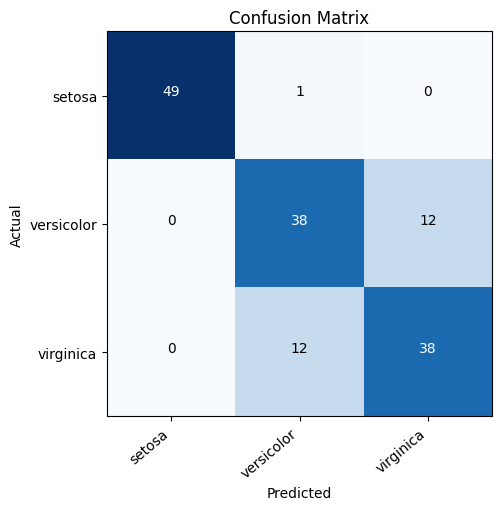

In [17]:
y_hat = model_1.predict(X)
labels = df["target"].unique()

matrix = confusion_matrix(y_true, y_hat, labels=labels, normalize=None)
print(matrix)

display_confusion_matrix(matrix, dataset.target_names)

<h1>Модель 2 (длина и ширина лепестка)</h1>  
Теперь для нашей второй модели мы собираемся использовать функции длины и ширины лепестка в качестве входных данных.

In [18]:
X = df[['petal length (cm)', 'petal width (cm)']]

model_2 = KNeighborsClassifier()
model_2.fit(X, y_true)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


__Model 2 Evaluation__

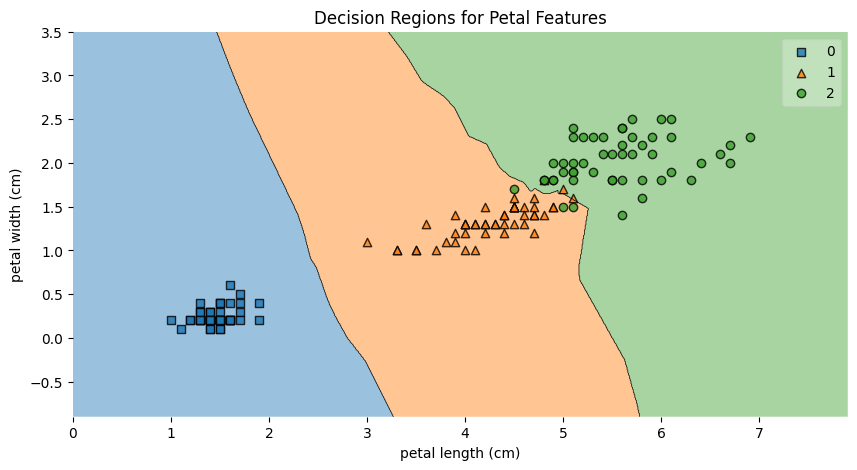

In [20]:
plot_decision_regions(X.values, y_true.values.astype(int), model_2)
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')
plt.title('Decision Regions for Petal Features')
plt.show()

[[50  0  0]
 [ 0 47  3]
 [ 0  3 47]]


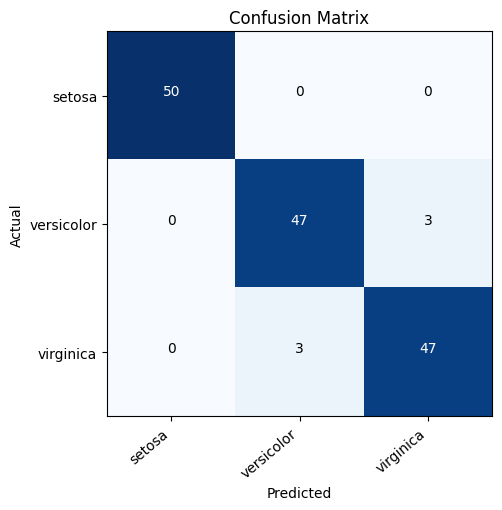

In [21]:
y_hat = model_2.predict(X)

matrix = confusion_matrix(y_true, y_hat, labels=labels, normalize=None)
print(matrix)

display_confusion_matrix(matrix, dataset.target_names)

<h1>Модель 3 (все функции)</h1>  
Теперь что касается нашей окончательной модели, мы собираемся использовать все доступные функции и обучить нашу модель KNN.

In [22]:
X = df.drop(['target'], axis=1)

In [23]:
model_3 = KNeighborsClassifier()
model_3.fit(X, y_true)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


__Модель 3 Оценка__

[[50  0  0]
 [ 0 47  3]
 [ 0  2 48]]


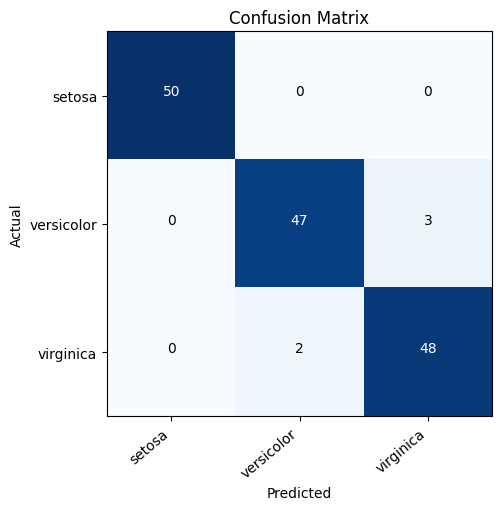

In [24]:
y_hat = model_3.predict(X)

matrix = confusion_matrix(y_true, y_hat, labels=labels, normalize=None)
print(matrix)

display_confusion_matrix(matrix, dataset.target_names)

Вы можете видеть, что окончательная модель со всеми функциями работает лучше, чем все другие модели. Меньше ошибочной классификации.

Однако до сих пор мы обучали и оценивали наши модели в одном и том же наборе данных. Использование одних и тех же данных для обучения и оценки не рекомендуется.

__Модель на разделенном наборе данных__

Здесь мы разделим наш набор данных на обучающий и тестовый набор и обучим нашу модель в обучающем наборе. Позже во время оценки мы собираемся использовать наш изолированный набор тестов.

In [25]:
X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

In [26]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [27]:
preds = knn.predict(X_test)

print(classification_report(preds, y_test))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        15
         1.0       0.93      0.88      0.90        16
         2.0       0.87      0.93      0.90        14

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



[[15  0  0]
 [ 0 14  1]
 [ 0  2 13]]


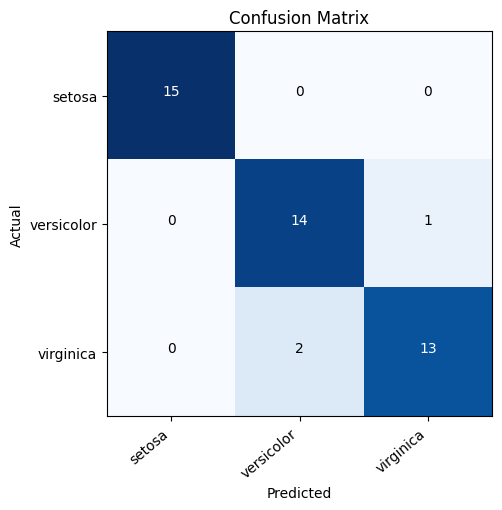

In [28]:
matrix = confusion_matrix(y_test, preds, labels=y.unique(), normalize=None)
print(matrix)

display_confusion_matrix(matrix, dataset.target_names)

Выше вы можете видеть, что точность нашего набора тестовых данных составляет 98%.

Из матрицы путаницы мы также видим, что у нас очень низкий уровень ошибок классификации.

Для наших вышеупомянутых моделей мы также можем использовать данные обучения и тестирования отдельно, оценивать эти модели, а затем выбирать лучшую модель.

<h1>Задание</h1>  
С помощью метода kNN определить качество красного вина. Использовать датасет winequality-red.csv, который находится той же папке.
Для этого разделить набор данных на обучающий и тестовый набор и обучим нашу модель в обучающем наборе. 
Построить матрицу путаници. Сделать выводы по полученным результатам. 

Распределение оценок качества:
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64


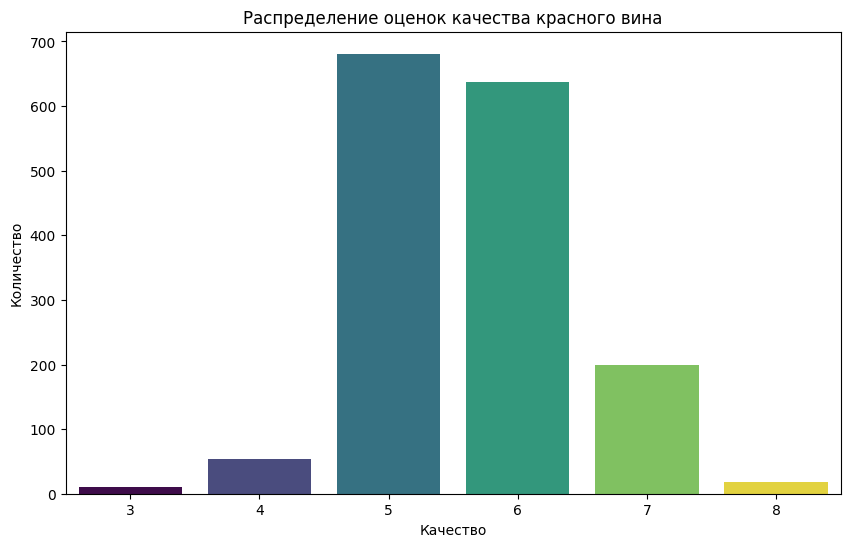


Уникальные значения качества: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
Количество классов: 6
Размер обучающей выборки: (1119, 11)
Размер тестовой выборки: (480, 11)

Распределение в обучающей выборке:
quality
3      7
4     37
5    477
6    446
7    139
8     13
Name: count, dtype: int64

Распределение в тестовой выборке:
quality
3      3
4     16
5    204
6    192
7     60
8      5
Name: count, dtype: int64
Точность модели: 0.5792
Точность модели в процентах: 57.92%
Матрица путаницы:
[[  0   0   1   2   0   0]
 [  0   0  12   4   0   0]
 [  0   0 143  57   4   0]
 [  0   1  59 113  19   0]
 [  0   0  10  28  22   0]
 [  0   0   0   4   1   0]]


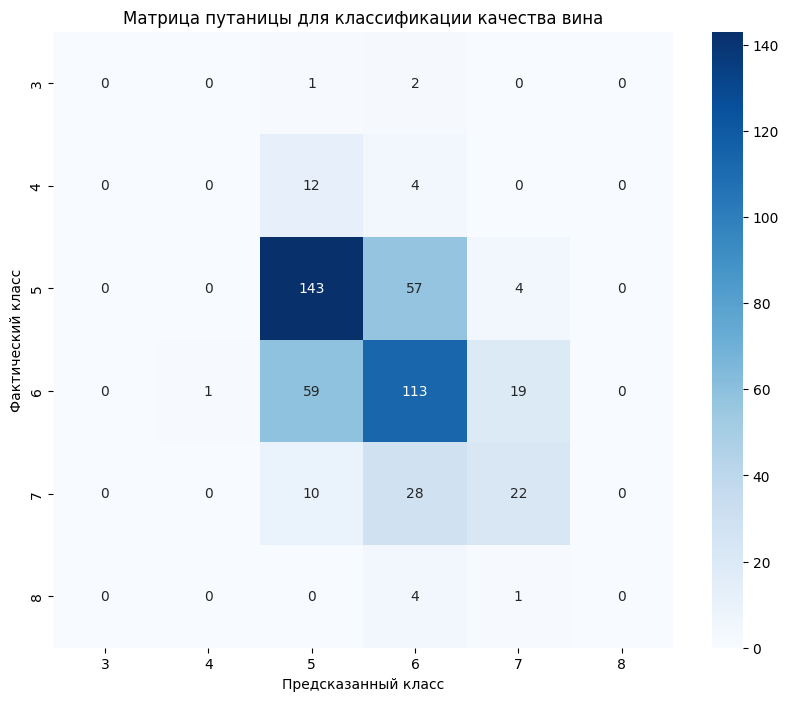


Отчет о классификации:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        16
           5       0.64      0.70      0.67       204
           6       0.54      0.59      0.56       192
           7       0.48      0.37      0.42        60
           8       0.00      0.00      0.00         5

    accuracy                           0.58       480
   macro avg       0.28      0.28      0.27       480
weighted avg       0.55      0.58      0.56       480



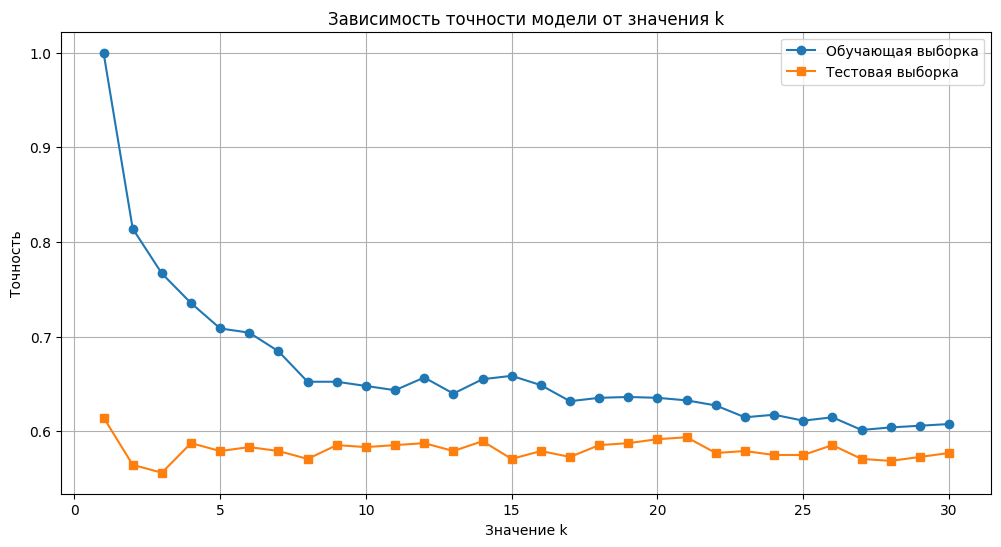

Лучшее значение k: 1
Лучшая точность на тестовой выборке: 0.6146 (61.46%)


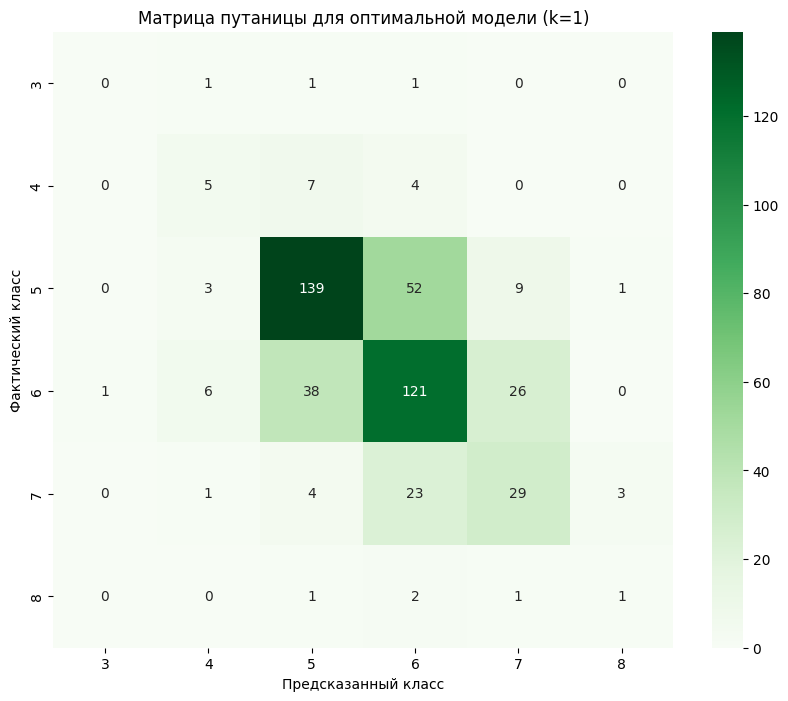


Финальная точность модели: 0.6146
Финальная точность в процентах: 61.46%
Корреляция признаков с качеством вина:
quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64


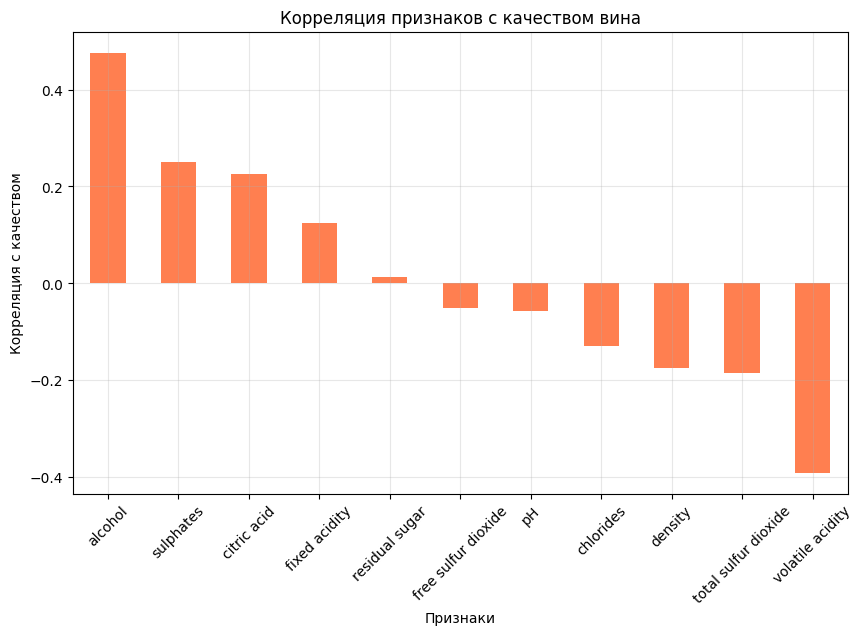

In [14]:
# Импорт необходимых библиотек
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# Настройка отображения
plt.rcParams["figure.figsize"] = (12, 8)

# Загрузка датасета
df_wine = pd.read_csv('winequality-red.csv', sep=',')

# Распределение качества вина
print("Распределение оценок качества:")
print(df_wine['quality'].value_counts().sort_index())

# Визуализация распределения
plt.figure(figsize=(10, 6))
sns.countplot(x='quality', data=df_wine, hue='quality', palette='viridis', legend=False)
plt.title('Распределение оценок качества красного вина')
plt.xlabel('Качество')
plt.ylabel('Количество')
plt.show()

# Проверим, является ли задача многоклассовой классификацией
unique_qualities = df_wine['quality'].unique()
print(f"\nУникальные значения качества: {sorted(unique_qualities)}")
print(f"Количество классов: {len(unique_qualities)}")

# Разделение на признаки (X) и целевую переменную (y)
X = df_wine.drop('quality', axis=1)
y = df_wine['quality']

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"\nРаспределение в обучающей выборке:")
print(y_train.value_counts().sort_index())
print(f"\nРаспределение в тестовой выборке:")
print(y_test.value_counts().sort_index())

# Создание и обучение модели
knn_wine = KNeighborsClassifier(n_neighbors=5)  # начнем с k=5
knn_wine.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = knn_wine.predict(X_test)

# Оценка точности
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy:.4f}")
print(f"Точность модели в процентах: {accuracy*100:.2f}%")

# Матрица путаницы
cm = confusion_matrix(y_test, y_pred)
print("Матрица путаницы:")
print(cm)

# Визуализация матрицы путаницы
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(unique_qualities), 
            yticklabels=sorted(unique_qualities))
plt.title('Матрица путаницы для классификации качества вина')
plt.xlabel('Предсказанный класс')
plt.ylabel('Фактический класс')
plt.show()

# Отчет о классификации
print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred))

# Поиск лучшего значения k
k_values = range(1, 31)
train_scores = []
test_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(k_values, train_scores, label='Обучающая выборка', marker='o')
plt.plot(k_values, test_scores, label='Тестовая выборка', marker='s')
plt.xlabel('Значение k')
plt.ylabel('Точность')
plt.title('Зависимость точности модели от значения k')
plt.legend()
plt.grid(True)
plt.show()

# Находим лучшее значение k
best_k = k_values[np.argmax(test_scores)]
best_accuracy = max(test_scores)
print(f"Лучшее значение k: {best_k}")
print(f"Лучшая точность на тестовой выборке: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

# Обучение финальной модели с оптимальным k
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)

# Предсказание
y_pred_best = best_knn.predict(X_test)

# Финальная матрица путаницы
cm_best = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens',
            xticklabels=sorted(unique_qualities),
            yticklabels=sorted(unique_qualities))
plt.title(f'Матрица путаницы для оптимальной модели (k={best_k})')
plt.xlabel('Предсказанный класс')
plt.ylabel('Фактический класс')
plt.show()

print(f"\nФинальная точность модели: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Финальная точность в процентах: {accuracy_score(y_test, y_pred_best)*100:.2f}%")

# Анализ важности признаков (через корреляцию с целевой переменной)
correlations = df_wine.corr()['quality'].sort_values(ascending=False)
print("Корреляция признаков с качеством вина:")
print(correlations)

# Визуализация корреляций
plt.figure(figsize=(10, 6))
correlations.drop('quality').plot(kind='bar', color='coral')
plt.title('Корреляция признаков с качеством вина')
plt.xlabel('Признаки')
plt.ylabel('Корреляция с качеством')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()